In [2]:

import re
from datetime import datetime
def extract_timeout_offsets(router_err_file, router_start_time: float):
    """
    Parse router_err_file for lines containing 'err: timeout'.
    Extract the Go-style timestamp, compute offset from router_start_time,
    and return a list of offsets (float seconds).
    """
    # Matches timestamps like 2025/09/13 13:04:19.701827
    pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d+)")
    results = []

    tz = ZoneInfo("Asia/Singapore")
    with open(router_err_file, "r") as f:
        for line in f:
            if "err: timeout" not in line:
                continue
            match = pattern.match(line)
            if match:
                ts_str = match.group(1)
                ts = datetime.strptime(ts_str, "%Y/%m/%d %H:%M:%S.%f").replace(tzinfo=tz)
                ts_float = ts.timestamp()
                offset = ts_float - router_start_time
                results.append(offset)

    return results

In [3]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
import re
# run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-10-15-18-30-01/run_0" tokenpipe
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-10-15-19-28-38/run_0" # distserve

GRAN = "30s"
memory_metric = "vllm:gpu_cache_usage_perc"
compute_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}]) / rate(vllm:iteration_tokens_total_count[{GRAN}])"
queue_metric = f"rate(vllm:request_queue_time_seconds_sum[{GRAN}])"
throughput_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}])"
# throughput_metric = f"vllm:avg_generation_throughput_toks_per_s"
req_counter_metric = f"router:req_counter"
rps_counter_metric = f"router:rps_counter"
tok_counter_metric = f"router:tok_counter"
tps_counter_metric = f"router:tps_counter"
ins_counter_metric = f"router:ins_counter"
ins_needed_metric = f"router:ins_needed"
tps_counter_map_metric = f"router:tps_counter_map"
coldstart_metric = f"router:create_instance_duration_seconds"
metrics_list = [memory_metric, compute_metric, throughput_metric, req_counter_metric, ins_counter_metric, ins_needed_metric, tok_counter_metric, queue_metric, rps_counter_metric, coldstart_metric, tps_counter_metric, tps_counter_map_metric]
report_file_path = analyze_data(run_log_dir, metrics_list)
with open(report_file_path, 'r') as f:
    report = json.load(f)

loadgen_data = report['loadgen_data']
total_request_count = len(loadgen_data)
no_response_count = 0
error_count = 0
skip_prefill_requests = []
requests = []
for request_data in loadgen_data:
    if 'error' not in request_data.keys():
        request = RequestData.init_from_dict(request_data)
        requests.append(request)
        if request.waiting_latency == 0:
            skip_prefill_requests.append(request)
        continue

    if request_data == {'error': 'No response!'}:
        no_response_count += 1
    else:
        error_count += 1
        print(request_data)

print(f"Total request: {total_request_count}, no response: {no_response_count}, error: {error_count}, skip prefill: {len(skip_prefill_requests)}")
recv_kv_failed_requests = report['recv_failed_requests']
print(f"There are totally {len(recv_kv_failed_requests)} requests fall back to model forwarding!")

start_str = report.get('router_start_time', 'N/A')
end_str = report.get('router_end_time', 'N/A')
print(start_str, end_str)
tz_sg = ZoneInfo("Asia/Singapore")
router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")
with open(f"{run_log_dir}/loadgen.err") as f:
    for line in f:
        m = pattern.match(line)
        if m:
            dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
            break

first_request_sendtime = dt.timestamp() + 5
print(f"Router start time: {router_start_time}, end time: {router_end_time}, first_request_sendtime: {first_request_sendtime - router_start_time}s")

Starting Prometheus...


ts=2025-10-15T11:52:42.486Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-10-15T11:52:42.486Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-10-15T11:52:42.486Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-10-15T11:52:42.486Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 e01c76a520c1 (none))"
ts=2025-10-15T11:52:42.486Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-10-15T11:52:42.487Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-10-15T11:52:42.494Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['vllm:gpu_cache_usage_perc', 'rate(vllm:iteration_tokens_total_sum[30s]) / rate(vllm:iteration_tokens_total_count[30s])', 'rate(vllm:iteration_tokens_total_sum[30s])', 'router:req_counter', 'router:ins_counter', 'router:ins_needed', 'router:tok_counter', 'rate(vllm:request_queue_time_seconds_sum[30s])', 'router:rps_counter', 'router:create_instance_duration_seconds', 'router:tps_counter', 'router:tps_counter_map']
params_list: [{'query': 'vllm:gpu_cache_usage_perc', 'start': '2025-10-15T11:30:04Z', 'end': '2025-10-15T13:30:04Z', 'step': '1s'}, {'query': 'rate(vllm:iteration_tokens_total_sum[30s]) / rate(vllm:iteration_tokens_total_count[30s])', 'start': '2025-10-15T11:30:04Z', 'end': '2025-10-15T13:30:04Z', 'step': '1s'}, {'query': 'rate(vllm:iteration_tokens_total_sum[30s])', 'start': '2025-10-15T11:30:04Z', 'end': '2025-10-15T13:30:04Z', 'step': '1s'}, {'query': 'router:req_counter', 'start': '2025-10-15T11:30:04Z', 'end': '2025-10-15T13:30:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
req_counter = report['prom_data']
prefill_model_name = "meta-llama/Llama-3.1-8B::prefill"
decode_model_name = "meta-llama/Llama-3.1-8B::decode"

router_metrics = req_counter.get("router", {})

first_request_arrival_time: 1760527809.1896584
[[1760527804, '1'], [1760527805, '1'], [1760527806, '1'], [1760527807, '1'], [1760527808, '1'], [1760527809, '1'], [1760527810, '1'], [1760527811, '1'], [1760527812, '1'], [1760527813, '1'], [1760527814, '1'], [1760527815, '1'], [1760527816, '1'], [1760527817, '1'], [1760527818, '1'], [1760527819, '1'], [1760527820, '1'], [1760527821, '1'], [1760527822, '1'], [1760527823, '1'], [1760527824, '1'], [1760527825, '1'], [1760527826, '1'], [1760527827, '1'], [1760527828, '1'], [1760527829, '1'], [1760527830, '1'], [1760527831, '1'], [1760527832, '1'], [1760527833, '1'], [1760527834, '1'], [1760527835, '1'], [1760527836, '1'], [1760527837, '1'], [1760527838, '1'], [1760527839, '1'], [1760527840, '1'], [1760527841, '1'], [1760527842, '1'], [1760527843, '1'], [1760527844, '1'], [1760527845, '1'], [1760527846, '1'], [1760527847, '1'], [1760527848, '1'], [1760527849, '1'], [1760527850, '1'], [1760527851, '1'], [1760527852, '1'], [1760527853, '1'], [1

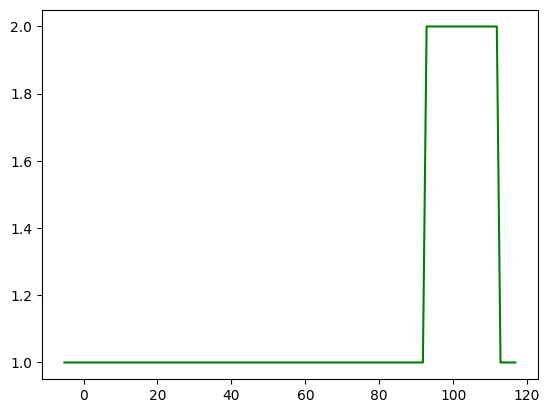

In [5]:

model_name = "meta-llama/Llama-3.1-8B::prefill"
metrics = router_metrics[model_name]
first_request_arrival_time = float('inf')
for request in requests:
    first_request_arrival_time = min(first_request_arrival_time, request.arrival_time)

print(f"first_request_arrival_time: {first_request_arrival_time}")


ins_needed_values = metrics.get(ins_needed_metric, [])
ins_needed_values = [
    t for t in ins_needed_values 
    if float(t[0]) <= router_end_time
]

timestamps = [float(t[0]) for t in ins_needed_values]
base_timestamp = min(timestamps)
timestamp_offsets = [t - first_request_arrival_time for t in timestamps]
plt.plot(
    timestamp_offsets,
    [float(t[1]) for t in ins_needed_values],
    label=ins_needed_metric,
    color='green'
)
print(ins_needed_values)
print(timestamp_offsets)
filtered_ins_needed_values = [int(t[1]) for t in ins_needed_values[6:]]
filtered_timestamps = timestamp_offsets[6:]

import json
data = {
    "timestamps": filtered_timestamps,
    "ins_needed": filtered_ins_needed_values,
    "min_instance": 1
}
with open("scale_trace.json", 'w+') as f:
    json.dump(data, f)

In [6]:
print(filtered_ins_needed_values)
scale_ups = []
scale_downs = []
for i in range(1, len(filtered_ins_needed_values)):
    prev_val = filtered_ins_needed_values[i - 1]
    curr_val = filtered_ins_needed_values[i]

    if curr_val > prev_val:
        scale_ups.append(i)
    elif curr_val < prev_val:
        scale_downs.append(i)

print(f"Scale-up events ({len(scale_ups)}): indices = {scale_ups}")
print(f"Scale-down events ({len(scale_downs)}): indices = {scale_downs}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Scale-up events (1): indices = [92]
Scale-down events (1): indices = [112]


Original events: [{'index': 92, 'scale': 1}, {'index': 112, 'scale': -1}]
Shifted events (index → scale): {91: 1, 112: -1}
Reconstructed absolute values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Scale-up events: 1
Scale-down events: 1


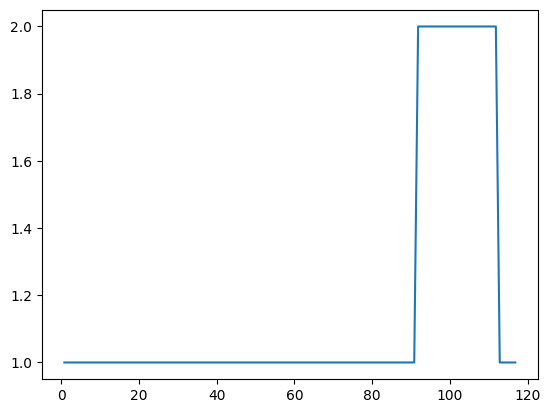

In [7]:
# Step 1: Detect scaling events
# Step 1: Detect scaling events
events = []
for i in range(1, len(filtered_ins_needed_values)):
    diff = filtered_ins_needed_values[i] - filtered_ins_needed_values[i - 1]
    if diff != 0:
        events.append({"index": i, "scale": diff})

print("Original events:", events)

# Step 2: Shift scale-up events one index earlier, merge collisions
shifted_events = {}
for ev in events:
    new_index = ev["index"] - 1 if ev["scale"] > 0 else ev["index"]
    shifted_events[new_index] = shifted_events.get(new_index, 0) + ev["scale"]

print("Shifted events (index → scale):", shifted_events)

# Step 3: Reconstruct absolute list
reconstructed = [filtered_ins_needed_values[0]]
for i in range(1, len(filtered_ins_needed_values)):
    delta = shifted_events.get(i, 0)
    new_val = reconstructed[-1] + delta
    reconstructed.append(new_val)

print("Reconstructed absolute values:", reconstructed)

# Step 4: Count scale-up / scale-down events
num_up = sum(1 for i in range(1, len(reconstructed)) if reconstructed[i] > reconstructed[i - 1])
num_down = sum(1 for i in range(1, len(reconstructed)) if reconstructed[i] < reconstructed[i - 1])

print(f"Scale-up events: {num_up}")
print(f"Scale-down events: {num_down}")
plt.plot(filtered_timestamps, reconstructed)
data = {
    "timestamps": filtered_timestamps,
    "ins_needed": reconstructed,
    "min_instance": 1
}
with open("blitzscale_spike.json", 'w+') as f:
    json.dump(data, f)

Original events: [{'index': 3, 'scale': 3}, {'index': 4, 'scale': -1}, {'index': 6, 'scale': 1}, {'index': 7, 'scale': -1}, {'index': 8, 'scale': 1}, {'index': 10, 'scale': -1}, {'index': 11, 'scale': 1}, {'index': 25, 'scale': -1}, {'index': 26, 'scale': 1}, {'index': 32, 'scale': -1}, {'index': 33, 'scale': 1}, {'index': 34, 'scale': -1}, {'index': 35, 'scale': 1}, {'index': 39, 'scale': -1}, {'index': 51, 'scale': 1}, {'index': 62, 'scale': -2}, {'index': 64, 'scale': 1}, {'index': 65, 'scale': -1}, {'index': 67, 'scale': 1}, {'index': 70, 'scale': -1}, {'index': 72, 'scale': 1}, {'index': 75, 'scale': 1}, {'index': 78, 'scale': -1}, {'index': 80, 'scale': 1}, {'index': 86, 'scale': -1}, {'index': 93, 'scale': 1}, {'index': 115, 'scale': -1}, {'index': 118, 'scale': 1}, {'index': 120, 'scale': 1}, {'index': 121, 'scale': -1}, {'index': 122, 'scale': -1}, {'index': 123, 'scale': 2}, {'index': 124, 'scale': -1}, {'index': 125, 'scale': 1}, {'index': 131, 'scale': -1}, {'index': 134, '

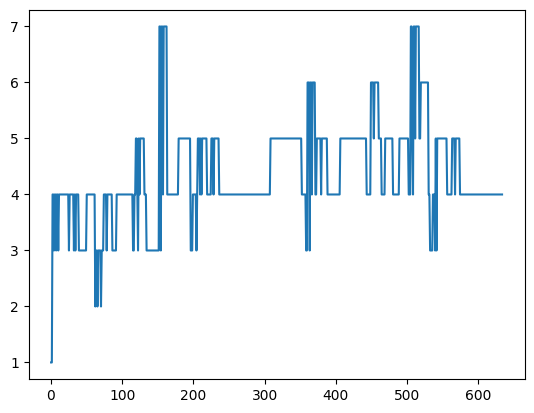

In [ ]:
# Step 1: Detect scaling events
events = []
for i in range(1, len(filtered_ins_needed_values)):
    diff = filtered_ins_needed_values[i] - filtered_ins_needed_values[i - 1]
    if diff != 0:
        events.append({"index": i, "scale": diff})

print("Original events:", events)

# Step 2: Shift scale-up events one index earlier, unless it collides with a scale-down event
shifted_events = {}

for ev in events:
    idx = ev["index"]
    scale = ev["scale"]

    # Default new index = shift earlier if scale-up
    new_index = idx - 1 if scale > 0 else idx

    # Check for collision:
    # If shifting would overlap with a scale-down event, don't shift
    if scale > 0 and any(e["index"] == new_index and e["scale"] < 0 for e in events):
        new_index = idx  # cancel the shift

    # Merge the scale at the final position
    shifted_events[new_index] = shifted_events.get(new_index, 0) + scale

print("Shifted events (index → scale):", shifted_events)

# Step 3: Reconstruct absolute list
reconstructed = [filtered_ins_needed_values[0]]
for i in range(1, len(filtered_ins_needed_values)):
    delta = shifted_events.get(i, 0)
    new_val = reconstructed[-1] + delta
    reconstructed.append(new_val)

print("Reconstructed absolute values:", reconstructed)

# Step 4: Count scale-up / scale-down events
num_up = sum(1 for i in range(1, len(reconstructed)) if reconstructed[i] > reconstructed[i - 1])
num_down = sum(1 for i in range(1, len(reconstructed)) if reconstructed[i] < reconstructed[i - 1])

print(f"Scale-up events: {num_up}")
print(f"Scale-down events: {num_down}")

plt.plot(filtered_timestamps, reconstructed)
data = {
    "timestamps": filtered_timestamps,
    "ins_needed": reconstructed,
    "min_instance": 1
}
with open("blitzscale_spike.json", 'w+') as f:
    json.dump(data, f)